In [20]:
import numpy as np 
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from lazypredict.Supervised import LazyRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from joblib import dump

print("done")

done


In [21]:
# #read csv
df = pd.read_csv("CH4_ML_dataset_1d_aqua.csv")
# # #filter outlier ch4
df = df[df['CH4_flux'] < 2000]

# #designate chamber data
# # Values to remove
# values_to_remove = ['1', '2', '5', '6']
# # Filter OUT chamber
# df = df[~df['Site'].isin(values_to_remove)]
# Filter TO chamber only
# df = df[df['Site'].isin(values_to_remove)]

# # Group and average data to remove triplicates
df = df.groupby(['Date', 'Site'])[['Latitude', 'Longitude', 'CH4_flux', 'CI', 'Chla.y', 'PAR', 'Kd490', 
                                   'rtoa1', 'rtoa2', 'rtoa3', 'rtoa4', 'rtoa5', 'rtoa6', 'rtoa7', 'rtoa8', 
                                   'rtoa9', 'rtoa10', 'rtoa11', 'rtoa12', 'ADG443', 'TSM', 'pr', 'pr3', 'pr5', 'pr7', 
                                   'tmmx', 'vs', 'water_temp_K']].mean()
df = df.reset_index()

#filter rows where imagery was NA (0)
# Columns to check for 0 values
cols_to_check = ['CI', 'Chla.y', 'PAR', 'Kd490', 'rtoa1', 'rtoa2', 'rtoa3', 'rtoa4', 'rtoa5', 'rtoa6', 'rtoa7', 'rtoa8', 'rtoa9', 'rtoa10', 'rtoa11', 'rtoa12', 'ADG443', 'TSM']

# Identify rows where all specified columns are 0
rows_to_remove = (df[cols_to_check] == 0).all(axis=1)

# Remove the identified rows
df = df[~rows_to_remove]

#create NDCI and MCI
df['NDCI'] = (df['rtoa8'] - df['rtoa11']) / (df['rtoa8'] + df['rtoa11'])

df['MCI'] = df['rtoa11'] - df['rtoa12'] - (df['rtoa10'] - df['rtoa12']) * ((708.75 - 753.75) / (681.25 - 753.75))

#first 5 rows
# df.head()

#num of rows
print(len(df))

#col names
print(list(df))

#num of NAs
# print(df.isna().sum())


135
['Date', 'Site', 'Latitude', 'Longitude', 'CH4_flux', 'CI', 'Chla.y', 'PAR', 'Kd490', 'rtoa1', 'rtoa2', 'rtoa3', 'rtoa4', 'rtoa5', 'rtoa6', 'rtoa7', 'rtoa8', 'rtoa9', 'rtoa10', 'rtoa11', 'rtoa12', 'ADG443', 'TSM', 'pr', 'pr3', 'pr5', 'pr7', 'tmmx', 'vs', 'water_temp_K', 'NDCI', 'MCI']


In [22]:
#remove 2 NA rows if using PR 5 or 7
df = df.dropna(subset=['pr5', 'NDCI'])

features = df[['CI', 'Chla.y', 'NDCI', 'MCI', 'PAR', 'Kd490', 'ADG443', 'TSM', 'pr5', 'water_temp_K', 'vs']]

feature_names = ['CI', 'Chla.y', 'NDCI', 'MCI', 'PAR', 'Kd490', 'ADG443', 'TSM', 'pr5', 'water_temp_K', 'vs']

features = features.to_numpy()

ch4 = df[["CH4_flux"]].to_numpy()

#try log transform
ln_ch4 = np.log(ch4)
#fill NAs (negatives) to 0 
ln_ch4 = np.nan_to_num(ln_ch4, nan=0)

info = df[["Date", "Site", "Latitude", "Longitude"]].to_numpy()

rs = 621

print(len(features))

121


In [23]:
#%% INITIAL TRAIN-TEST SPLIT (holdout 10% for final training)
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test, info_train, info_test = train_test_split(
    features, ln_ch4, info, test_size = 0.1, random_state = rs)

print(len(x_train))


108


In [10]:
#lazy regressor analysis of all models
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(x_train, x_test, y_train, y_test)

print(models)

In [24]:
# Create a Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=110, random_state= rs)

# Train the model
rf_regressor.fit(x_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(x_test)

# Evaluate the model using R-squared
rf_r2 = r2_score(y_test, y_pred)
rf_mse = mean_absolute_error(y_test, y_pred)
print(f"RF Mean Absolute Error: {rf_mse}")
print("RF R-squared:", rf_r2)

from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor(n_estimators=100, random_state=rs)

# Train the model
etr.fit(x_train, y_train)

# Make predictions on the test set
etr_y_pred = etr.predict(x_test)

# Evaluate the model using R-squared
etr_r2 = r2_score(y_test, etr_y_pred)
etr_mse = mean_absolute_error(y_test, etr_y_pred)
print(f"ETR Mean Absolute Error: {etr_mse}")
print("ETR R-squared:", etr_r2)


#XGBR
from xgboost import XGBRegressor

# Initialize the XGBRegressor
xgbr = XGBRegressor(n_estimators=100, random_state=rs)

# Train the model
xgbr.fit(x_train, y_train)

# Make predictions on the test set
xgbr_y_pred = xgbr.predict(x_test)

# Evaluate the model using R-squared and MAE
xgbr_r2 = r2_score(y_test, xgbr_y_pred)
xgbr_mae = mean_absolute_error(y_test, xgbr_y_pred)

print(f"XGBR Mean Absolute Error: {xgbr_mae}")
print("XGBR R-squared:", xgbr_r2)

RF Mean Absolute Error: 1.167484669578953
RF R-squared: 0.05798134860923576
ETR Mean Absolute Error: 1.1315936268888829
ETR R-squared: 0.12892279024179576
XGBR Mean Absolute Error: 0.9172365211059377
XGBR R-squared: 0.34432953155695434


In [6]:
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# new scoring functions
def mre(y_true, y_pred):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  # Avoid division by zero
  y_true_non_zero = np.where(y_true != 0, y_true, 1) 

  relative_errors = np.abs((y_true - y_pred) / y_true_non_zero)
  mre = np.mean(relative_errors)
  return mre

def rmse_log(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = (y_true > -1) & (y_pred > -1)
    return np.sqrt(np.mean((np.log1p(y_true[mask]) - np.log1p(y_pred[mask])) ** 2))

def rrmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2)) / np.mean(y_true)

# Define scorers
scorers = {
    'r2': 'r2',
    'mae': 'neg_mean_absolute_error',
    'mre': make_scorer(mre, greater_is_better=False),
    'rmse_log': make_scorer(rmse_log, greater_is_better=False),
    'rrmse': make_scorer(rrmse, greater_is_better=False)
}

# Repeated K-Fold setup
rkf = RepeatedKFold(n_splits=10, n_repeats=2, random_state=42)

def run_cv(model, name):
    cv_results = cross_validate(
        estimator=model,
        X=x_train,
        y=y_train.ravel(),
        cv=rkf,
        scoring=scorers,
        return_train_score=False,
        n_jobs=-1
    )

    # Extract and correct scores
    mae_scores = -cv_results['test_mae']
    mre_scores = -cv_results['test_mre']
    rmse_log_scores = -cv_results['test_rmse_log']
    rrmse_scores = -cv_results['test_rrmse']
    r2_scores = cv_results['test_r2']

    print(f"\n{name} CV Results:")
    print(f"Mean R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    print(f"Max R²: {np.max(r2_scores):.4f}")
    print(f"Mean MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
    print(f"Mean MRE: {np.mean(mre_scores):.4f} ± {np.std(mre_scores):.4f}")
    print(f"Mean RMSE(log): {np.mean(rmse_log_scores):.4f} ± {np.std(rmse_log_scores):.4f}")
    print(f"Mean RRMSE: {np.mean(rrmse_scores):.4f} ± {np.std(rrmse_scores):.4f}")

# Run for each model
run_cv(xgbr, "Repeated XGBR")
run_cv(etr, "Repeated ETR")
run_cv(rf_regressor, "Repeated RF")



Repeated XGBR CV Results:
Mean R²: 0.2887 ± 0.4121
Max R²: 0.8438
Mean MAE: 1.0109 ± 0.2435
Mean MRE: 1.5813 ± 2.0381
Mean RMSE(log): 0.5048 ± 0.1090
Mean RRMSE: 0.8567 ± 0.3827

Repeated ETR CV Results:
Mean R²: 0.4634 ± 0.2474
Max R²: 0.8688
Mean MAE: 0.9417 ± 0.2105
Mean MRE: 1.1889 ± 0.6575
Mean RMSE(log): 0.4831 ± 0.0820
Mean RRMSE: 0.7653 ± 0.3111

Repeated RF CV Results:
Mean R²: 0.4441 ± 0.2379
Max R²: 0.8135
Mean MAE: 0.9319 ± 0.1689
Mean MRE: 1.2861 ± 0.9841
Mean RMSE(log): 0.4813 ± 0.0810
Mean RRMSE: 0.7943 ± 0.4083


In [ ]:
# Tuning XGBR
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(100, 1500, 50)],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# Define scoring metrics
scoring = {
    "R2": "r2", 
    "MAE": "neg_mean_absolute_error", 
    "MAPE": "neg_mean_absolute_percentage_error"
}

# Base model
xgbr = XGBRegressor(objective='reg:squarederror', random_state=rs)

# K-Fold setup
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Grid Search
xgbr_random = GridSearchCV(
    estimator=xgbr,
    param_grid=param_grid,  
    cv=kf,
    verbose=2,
    scoring=scoring,
    refit="MAE",
    n_jobs=-1
)

# Fit it
xgbr_random.fit(x_train, y_train.ravel())

# Best parameters
print("Best Parameters:\n", xgbr_random.best_params_)


In [ ]:
#Best XGBR
# Initialize the XGBRegressor
# Create a new model using the best parameters from the search
# Best Parameters:
# 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 414, 'subsample': 0.8
best_xgbr = XGBRegressor(**xgbr_random.best_params_, objective='reg:squarederror', random_state=rs)

run_cv(best_xgbr, "Tuned XGBR")


Tuned XGBR CV Results:
Mean R²: 0.4150 ± 0.2858
Max R²: 0.8775
Mean MAE: 0.9413 ± 0.2246
Mean MRE: 1.2780 ± 1.2504
Mean RMSE(log): 0.4682 ± 0.1031
Mean RRMSE: 0.7944 ± 0.3555


In [ ]:
# Hyperparameter tuning
#%% GRID SEARCH CV ETR
from sklearn.model_selection import GridSearchCV

#define scoring metrics
scoring = {"R2": "r2", 
           "MAE": "neg_mean_absolute_error", 
           "MAPE": "neg_mean_absolute_percentage_error"}


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1500, num = 10)]

# Define parameter grid (reduced to avoid huge combinations)
param_grid = {
    'n_estimators': n_estimators,
    'max_features': ['log2', 'sqrt', 1.0],
    'max_depth': [10, 30, None],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2, 4]
}

# Base model
etr = ExtraTreesRegressor(random_state=rs)

# K-Fold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Grid Search
etr_grid = GridSearchCV(
    estimator=etr, 
    param_grid=param_grid,
    cv=kf, 
    verbose=2,
    scoring=scoring,
    refit="MAE",
    n_jobs=-1
)

# Fit the model
etr_grid.fit(x_train, y_train.ravel())

# Show best parameters
print("Best Parameters:\n", etr_grid.best_params_)


In [25]:
# Best ETR
# Create an Extra Trees Regressor model
# 'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 255
best_etr = ExtraTreesRegressor(n_estimators=255, 
                          min_samples_split = 2,
                          min_samples_leaf = 1,
                          max_features = 1.0,
                          max_depth = 10,
                          random_state=rs)

run_cv(best_etr, "Tuned ETR")


Tuned ETR CV Results:
Mean R²: 0.4816 ± 0.2262
Max R²: 0.8679
Mean MAE: 0.9380 ± 0.2132
Mean MRE: 1.2095 ± 0.6431
Mean RMSE(log): 0.4781 ± 0.0857
Mean RRMSE: 0.7580 ± 0.3186


In [ ]:
# Hyperparameter tuning
#%% GRID SEARCH CV RFR
from sklearn.model_selection import RandomizedSearchCV

#define scoring metrics
scoring = {"R2": "r2", 
           "MAE": "neg_mean_absolute_error", 
           "MAPE": "neg_mean_absolute_percentage_error"}


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

# Define parameter grid (reduced to avoid huge combinations)
param_grid = {
    'n_estimators': n_estimators,
    'max_features': ['log2', 1.0],
    'max_depth': [10, 30, None],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2, 4]
}

# Base model
rfr = RandomForestRegressor(random_state=rs)

# K-Fold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Grid Search
rfr_grid = GridSearchCV(
    estimator=rfr, 
    param_grid=param_grid,
    cv=kf, 
    verbose=2,
    scoring=scoring,
    refit="MAE",
    n_jobs=-1
)

# Fit the model
rfr_grid.fit(x_train, y_train.ravel())

# Show best parameters
print("Best Parameters:\n", rfr_grid.best_params_)

In [28]:
# Best RFR
# Create an RFR model
#  {'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}
best_rfr = RandomForestRegressor(n_estimators=800, 
                          min_samples_split = 2,
                          min_samples_leaf = 1,
                          max_features = 1.0,
                          max_depth = 10,
                          random_state=rs)

run_cv(best_rfr, "Tuned RFR")


Tuned RFR CV Results:
Mean R²: 0.4493 ± 0.2366
Max R²: 0.8389
Mean MAE: 0.9324 ± 0.1696
Mean MRE: 1.2679 ± 0.9131
Mean RMSE(log): 0.4800 ± 0.0859
Mean RRMSE: 0.7903 ± 0.4084


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score
from sklearn.base import clone

# Set up Repeated K-Fold
rkf = RepeatedKFold(n_splits=10, n_repeats=2, random_state=42)

r2_scores = []
fold_predictions = []

# Collect all true/predicted values for global axis limits
all_true_vals = []
all_pred_vals = []

# For CSV
csv_data = []

# Loop through each fold
for i, (train_idx, test_idx) in enumerate(rkf.split(x_train)):
    X_tr, X_te = x_train[train_idx], x_train[test_idx]
    y_tr, y_te = y_train[train_idx], y_train[test_idx]

    model = clone(best_etr)
    model.fit(X_tr, y_tr.ravel())

    y_tr_pred = model.predict(X_tr)
    y_te_pred = model.predict(X_te)

    r2 = r2_score(y_te, y_te_pred)
    r2_scores.append(r2)
    fold_predictions.append((y_tr, y_tr_pred, y_te, y_te_pred))

    # Flatten before collecting to avoid dimension mismatch
    all_true_vals.extend(y_tr.ravel())
    all_true_vals.extend(y_te.ravel())
    all_pred_vals.extend(np.ravel(y_tr_pred))
    all_pred_vals.extend(np.ravel(y_te_pred))

    # Collect CSV data for training set
    for true_val, pred_val in zip(y_tr.ravel(), y_tr_pred):
        csv_data.append({
            'Fold': i + 1,
            'Set': 'Train',
            'True': true_val,
            'Predicted': pred_val
        })

    # Collect CSV data for test set
    for true_val, pred_val in zip(y_te.ravel(), y_te_pred):
        csv_data.append({
            'Fold': i + 1,
            'Set': 'Test',
            'True': true_val,
            'Predicted': pred_val
        })

# Create DataFrame and write to CSV
df = pd.DataFrame(csv_data)
# df.to_csv('fold_predictions.csv', index=False)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score
from sklearn.base import clone

# Set up Repeated K-Fold
rkf = RepeatedKFold(n_splits=10, n_repeats=2, random_state=42)

# Prepare figure
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()

r2_scores = []
fold_predictions = []

# Collect all true/predicted values for global axis limits
all_true_vals = []
all_pred_vals = []

# Loop through each fold
for i, (train_idx, test_idx) in enumerate(rkf.split(x_train)):
    X_tr, X_te = x_train[train_idx], x_train[test_idx]
    y_tr, y_te = y_train[train_idx], y_train[test_idx]

    model = clone(best_etr)
    model.fit(X_tr, y_tr.ravel())

    y_tr_pred = model.predict(X_tr)
    y_te_pred = model.predict(X_te)

    r2 = r2_score(y_te, y_te_pred)
    r2_scores.append(r2)
    fold_predictions.append((y_tr, y_tr_pred, y_te, y_te_pred))

    # Flatten before collecting to avoid dimension mismatch
    all_true_vals.extend(y_tr.ravel())
    all_true_vals.extend(y_te.ravel())
    all_pred_vals.extend(np.ravel(y_tr_pred))
    all_pred_vals.extend(np.ravel(y_te_pred))

# Determine best fold by R²
best_idx = np.argmax(r2_scores)

# Filter out zeros and negatives for log scale
combined_vals = np.concatenate([all_true_vals, all_pred_vals])
combined_vals = combined_vals[combined_vals > 0]
min_val, max_val = combined_vals.min(), combined_vals.max()

# Plot each fold
for i, (y_tr, y_tr_pred, y_te, y_te_pred) in enumerate(fold_predictions):
    ax = axes[i]
    ax.scatter(y_tr, y_tr_pred, color='green', alpha=0.5, label='Train')
    ax.scatter(y_te, y_te_pred, color='gold', edgecolor='black', alpha=0.8, label='Test')

    # Set log scale and global limits
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(0, 50)
    ax.set_ylim(0, 50)

    # 1:1 reference line
    ax.plot([0, 50], [0, 50], 'k--', lw=1)

    # Title with R² and asterisk for best fold
    title = f"Fold {i+1} (R²: {r2_scores[i]:.2f})"
    if i == best_idx:
        title += " *"
    ax.set_title(title, fontsize=10)

    ax.set_xlabel("Observed", fontsize=8)
    ax.set_ylabel("Predicted", fontsize=8)
    ax.tick_params(axis='both', which='both', labelsize=8)

# Add legend only once
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=12)

fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle("Repeated K-Fold (RFR) - Log Scale Predictions", fontsize=16)
plt.show()


In [ ]:
# #write obs vs pred to csv for manual stat calc
best_etr.fit(x_train, y_train)

y_pred = best_etr.predict(x_test)

# Create dataframes
best_rf_csv = pd.DataFrame(y_pred, columns=['pred_ch4'])
y_test_csv = pd.DataFrame(y_test, columns=['ch4'])
x_test_csv = pd.DataFrame(x_test, columns=feature_names)
info_test_csv = pd.DataFrame(info_test, columns=['Date', 'Site', 'Lat', 'Long'])  # Make sure `info` matches x_test

# Combine everything
combined_csv = pd.concat([
    y_test_csv.reset_index(drop=True),
    best_rf_csv,
    x_test_csv.reset_index(drop=True),
    info_test_csv.reset_index(drop=True)
], axis=1)

# Save to CSV
# combined_csv.to_csv('etr_obs_vs_pred.csv', index=False)


In [26]:
# Final train on all data and save model
best_etr_final = best_etr.fit(features, ln_ch4)

#dump model for raster application
# dump(best_etr_final, 'etr_final.joblib')

In [28]:
# Apply best model to all chamber data
# #read csv
ch_rs_df = pd.read_csv("chamber_rs_df.csv")
# rename chla to match model
ch_rs_df['Chla.y'] = ch_rs_df['Chla']

#filter rows where imagery was NA (0)
# Columns to check for 0 values
cols_to_check = ['CI', 'Chla.y', 'PAR', 'Kd490', 'rtoa1', 'rtoa2', 'rtoa3', 'rtoa4', 'rtoa5', 'rtoa6', 'rtoa7', 'rtoa8', 'rtoa9', 'rtoa10', 'rtoa11', 'rtoa12', 'ADG443', 'TSM']

# Identify rows where all specified columns are 0
rows_to_remove = (ch_rs_df[cols_to_check] == 0).all(axis=1)

# Remove the identified rows
ch_rs_df = ch_rs_df[~rows_to_remove]

#create NDCI and MCI
ch_rs_df['NDCI'] = (ch_rs_df['rtoa8'] - ch_rs_df['rtoa11']) / (ch_rs_df['rtoa8'] + ch_rs_df['rtoa11'])

ch_rs_df['MCI'] = ch_rs_df['rtoa11'] - ch_rs_df['rtoa12'] - (ch_rs_df['rtoa10'] - ch_rs_df['rtoa12']) * ((708.75 - 753.75) / (681.25 - 753.75))

ch_rs_features = ch_rs_df[['CI', 'Chla.y', 'NDCI', 'MCI', 'PAR', 'Kd490', 'ADG443', 'TSM', 'pr5', 'water_temp_K', 'vs']]

# Apply model
ch_rs_df['Predicted'] = best_etr_final.predict(ch_rs_features)

# Save to CSV
ch_rs_df.to_csv("chamber_rs_with_predictions.csv", index=False)

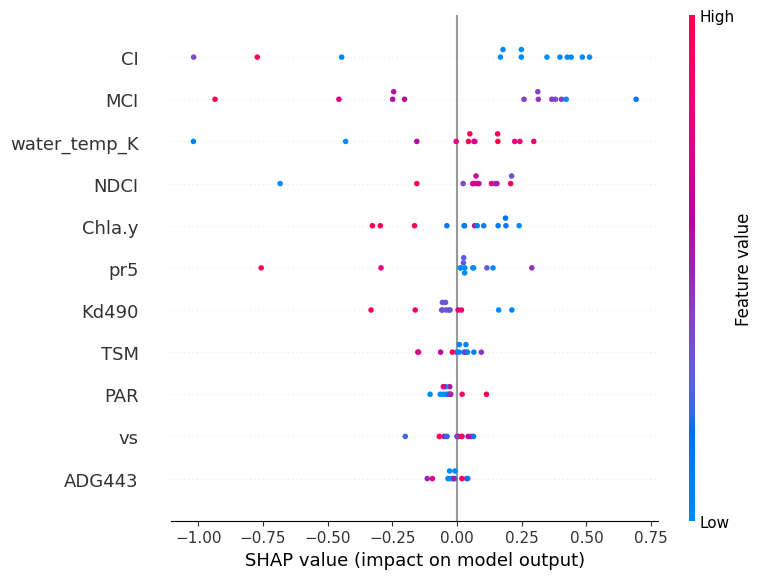

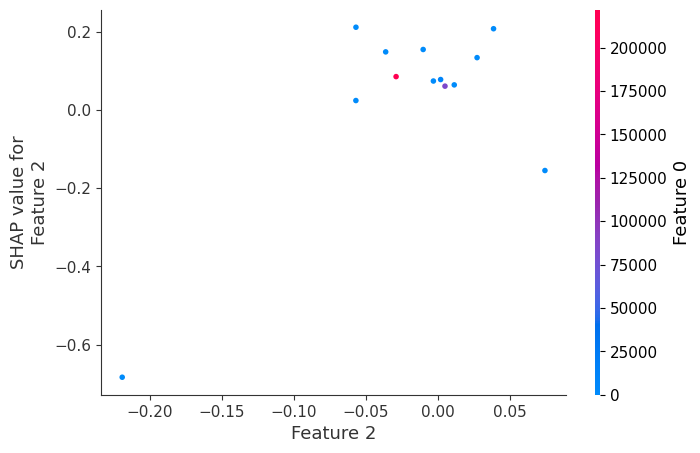

In [ ]:
#SHAP
import shap
# Create a TreeExplainer object
explainer = shap.TreeExplainer(best_etr)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(x_test)

# Visualize SHAP values (e.g., using a summary plot)
shap.summary_plot(shap_values, x_test, feature_names = feature_names)

# Generate a SHAP dependence plot for a specific feature (e.g., age)
shap.dependence_plot('Feature 2', shap_values, x_test)

# Partial dependence plot w CI/MCI/CHLA

Text(0.5, 1.0, 'ETR')

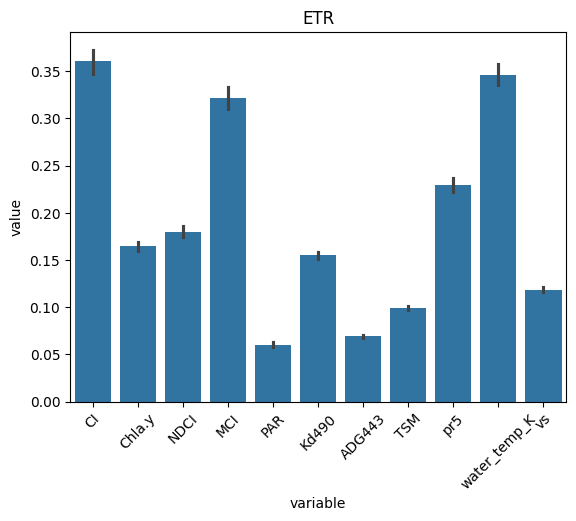

In [45]:
#%% FEATURE IMPORTANCE 
from sklearn.inspection import permutation_importance
import seaborn as sns

scoring = {"R2": "r2", 
           "MAE": "neg_mean_absolute_error", 
           "MAPE": "neg_mean_absolute_percentage_error"}

result = permutation_importance(
    best_etr, x_test, y_test,
    n_repeats=500, 
    random_state=rs, 
    n_jobs=-1,
    scoring=scoring)

#%% Plot RF importances
rf_perm_imp = pd.DataFrame(result['MAE']['importances'], index=feature_names).T

perm_imp_long = pd.melt(rf_perm_imp)
g = sns.barplot(data = perm_imp_long, x = 'variable',y='value')
plt.xticks(rotation=45)
plt.title("ETR")